# WATER BAG CLUSTERS IN RIO DE JANEIRO - MEANSHIFT HYPERPARAMETER TUNING

---
### Notebook Sections:

1. Utility functions
1. Data Cleaning
2. Hyperparameter Tuning
3. Final Model
4. Cluster Result Analysis

### Import modules and functions

In [1]:
import os, sys, pandas as pd, numpy as np, matplotlib.pyplot as plt, seaborn as sns; sns.set()
from IPython.display import clear_output as co

### Define data class to host data paths
class DATA:
    project = 'Desktop/Repositories/Data Science Projects/Hackaton COR IV - Centro de Operações do RJ/ACELERAÇÃO/Modulos'
    path = r'C:\Users\luisr\Desktop\Repositories\Dados\Desafio COR-Rio IV\\'
    AlertaAPI = r'http://websempre.rio.rj.gov.br/json/chuvas'

#### Change project root folder

In [2]:
cd ../

C:\Users\luisr\Desktop\Repositories\Data Science Projects\Hackaton COR IV - Centro de Operações do RJ\ACELERAÇÃO


### Load data

In [3]:
catalog = pd.read_csv('Dados/Catalog/water_bag_catalog_google.csv'); data = catalog.copy()
data[['EVENTO_ID', 'EVENTO_TITULO', 'EVENTO_DESCRICAO', 'EVENTO_LATITUDE', 'EVENTO_LONGITUDE', 'EVENTO_INICIO']].head()

,EVENTO_ID,EVENTO_TITULO,EVENTO_DESCRICAO,EVENTO_LATITUDE,EVENTO_LONGITUDE,EVENTO_INICIO
0,1258,Bolsão d'agua,R. Pinheiro Machado com Muniz Barreto - Botafogo,-22.944774,-43.183917,2015-09-12 20:12:00
1,1259,Bolsão,"Av. Novo Rio, 3131 - Bonsucesso",-22.871684,-43.256200,2015-09-12 22:13:00
2,1260,Bolsão,"Av. Ataulfo de Paiva, 752 - Leblon",-22.984337,-43.223100,2015-09-12 22:15:00
3,1261,Bolsão,Avenida General San Martin / Praça Antero de Q...,-22.984337,-43.223100,2015-09-12 22:16:00
4,1263,Bolsão d'água,"Av. Brasil, 40 - São Cristóvão",-22.892179,-43.216400,2015-09-13 06:30:00


---
## 0. Utility functions

#### Unsupervised learning algorithms, evaluation metrics and preprocessing functions

In [4]:
from sklearn import cluster, mixture, metrics
from sklearn.preprocessing import MinMaxScaler as mms, LabelEncoder as le

#### Plot colored and connected coordinates in 2D plane

In [5]:
from Modulos.coord_plot import (
    cmaps, filter_group_size,
    cluster_algo_comparison,
    connect_coordinates_colored,
    min_group_size_progression_plot,
    atemporal_evolution_plot
)

#### Cluster hyperparameter tunning module

In [6]:
from Modulos.cluster_tunning import (
    labels_size_stats,
    log_range,
    cluster_grid_search,
    evaluate_labels,
    min_samples_analysis,
    rotate_3d_plot
)

---
# 1. Data Cleaning

#### Data type conversion

In [7]:
float_cols = ['EVENTO_LATITUDE', 'EVENTO_LONGITUDE', 'search_lat', 'search_lng']

data[float_cols] = data[float_cols].astype(float)

---
# 2. Meanshift Cluster Model Hyperparameter Tunning

### Scale algorithm input data

In [8]:
# Fit algotihm on incidents coordintes
profile_cols = ['EVENTO_LONGITUDE', 'EVENTO_LATITUDE']

coords = pd.DataFrame(mms().fit_transform(data[profile_cols]), columns=profile_cols, index=data.index)

### Hyperparameter grid search settings

In [9]:
# Set base algorithm for evaluation
alg = meanshift = cluster.MeanShift(
    bandwidth=None, cluster_all=False,
    max_iter=1000, n_jobs=-1
)

# Set parameters for grid search
param_name = 'bandwidth'
min_value = 0.001
max_value = 0.02
n_params = 20
params= np.linspace(min_value, max_value, n_params); params

array([0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009,
       0.01 , 0.011, 0.012, 0.013, 0.014, 0.015, 0.016, 0.017, 0.018,
       0.019, 0.02 ])

### Build and evaluate model with grid search in parameter space 

In [27]:
# Perform parameter space grid search
labels = cluster_grid_search(coords, alg, param_name, params)

# Evaluate parameter search results
scrs = evaluate_labels(coords, labels, param_name, min_samples=10)

# Evaluate parameter search results
min_samples = min_samples_analysis(coords, labels, param_name, min_samples=0, max_samples=25)

20/20 Search grid evaluation...


### Save grid search result

In [12]:
res_path = 'Dados/Cluster Tunning/'

results = {
#     'Grid Search Labels': pd.DataFrame(labels, index=catalog['EVENTO_ID']),
#     'Grid Search Results': scrs,
#     'Grid Search Min Samples Analysis': min_samples
}

# Save results
for i, (key, res) in enumerate(results.items()):
    co(wait=True); print(f'{i+1}/{len(results)} - Saving result: {key}...')
#     res.to_csv(res_path + key + '.csv', index=True)

### Reload grid search results

In [13]:
from Modules.data import read_csv_folder

res_path = 'Dados/Cluster Tunning/'

# Reload results
labels, min_samples, scrs = read_csv_folder(res_path, index_col=0)
labels = {label: labels[label].values for label in labels}

---
# 3. Visualize Hyperparameter Grid Search

### 2D Grid search result

In [ ]:
band_scrs = scrs.set_index('bandwidth')

fig, axs = plt.subplots(1, 2, figsize=(14, 3.5))
band_scrs[['n_labels', 'n_outlabels']].plot(marker='o', ax=axs[0])
band_scrs[['n_inlabels']].plot(marker='o', ax=axs[1])
# ax.set(xlim=(0, 0.1))

fig, axs = plt.subplots(1, 2, figsize=(14, 3.5))
band_scrs[['n_in', 'n_out', 'n_non_outliers', 'n_outliers_label']].plot(marker='o', ax=axs[0])
band_scrs[['n_outliers']].plot(marker='o', ax=axs[1])

fig, axs = plt.subplots(1, 2, figsize=(14, 3.5))
pd.DataFrame(
    mms().fit_transform(band_scrs[['silhouette', 'bouldin']]),
    columns=['silhouette', 'bouldin'], index=band_scrs.index
).plot(marker='o', ax=axs[0])
band_scrs[['inertia']].plot(marker='o', ax=axs[1])

plt.show()

### 3D Grid search result

In [29]:
x = 'bandwidth'
y = 'min_samples'
z = 'n_inlabels'
zz = 'n_outliers'
w = 'inertia'
ww = 'silhouette'
www = 'bouldin'
wwww = 'calinski'

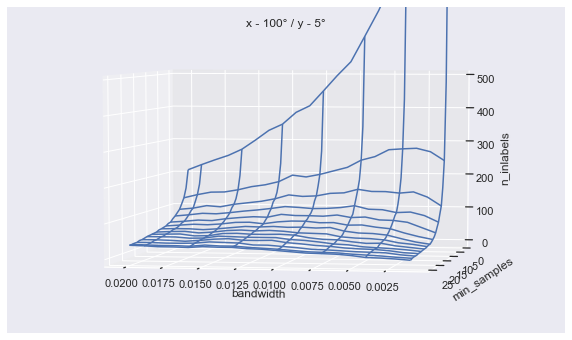

In [30]:
rotate_3d_plot(min_samples, x, y, z, xy_start=0, xy_end=5, z_start=0, z_end=100, frames=15, zlim=(-10, 500), cstride=2, rstride=3, wire=True)

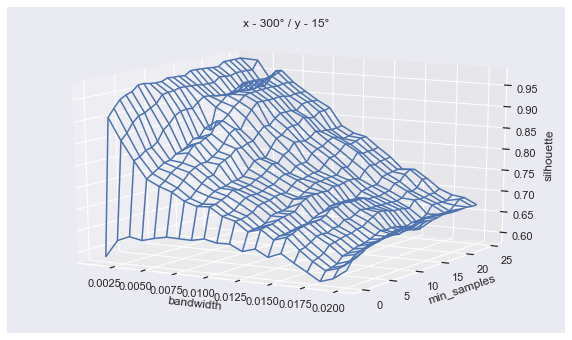

In [31]:
rotate_3d_plot(min_samples, x, y, ww, xy_start=0, xy_end=15, z_start=0, z_end=300, frames=15, zlim=None)

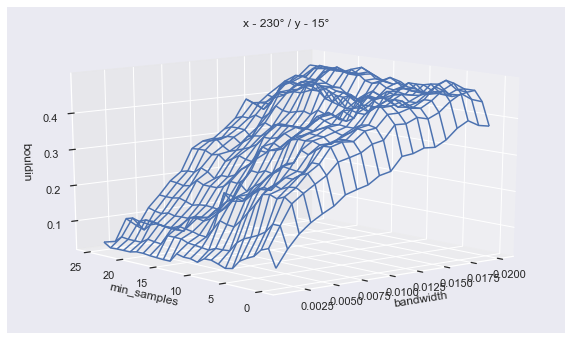

In [32]:
rotate_3d_plot(min_samples, x, y, www, xy_start=0, xy_end=15, z_start=0, z_end=230, frames=15, zlim=None)

### 2D Orthogonal views

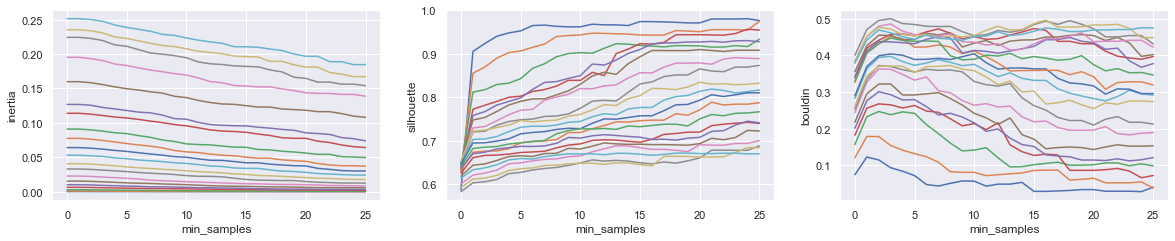

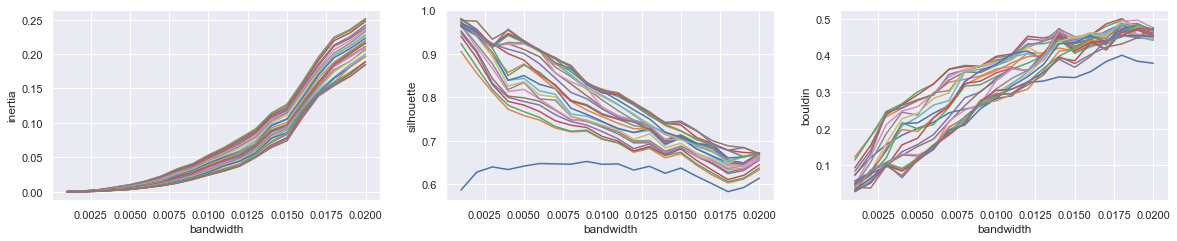

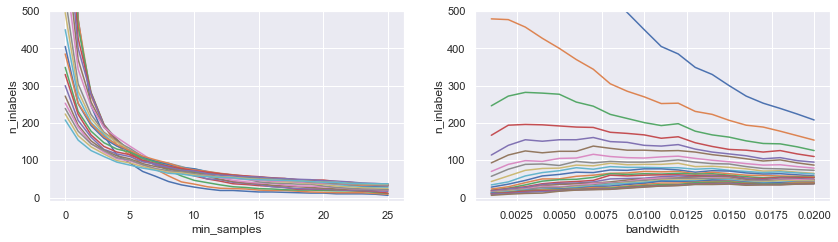

In [33]:
fig, axs = plt.subplots(1, 3, figsize=(20, 3.5))
for W, ax in zip([w, ww, www], axs):
    for index, df in min_samples.groupby(x):
        df.set_index(y)[W].plot(ax=ax)
    ax.set(xlabel=y, ylabel=W)

fig, axs = plt.subplots(1, 3, figsize=(20, 3.5))
for W, ax in zip([w, ww, www], axs):
    for index, df in min_samples.groupby(y):
        df.set_index(x)[W].plot(ax=ax)
    ax.set(xlabel=x, ylabel=W)

fig, axs = plt.subplots(1, 2, figsize=(14, 3.5))
for X, Y, ax in zip([x, y], [y, x], axs):
    for index, df in min_samples.groupby(X):
        df.set_index(Y)[z].plot(ax=ax)
    ax.set(xlabel=Y, ylabel=z, ylim=(-10, 500))